In [1]:
using Pkg
Pkg.activate("../")

  Activating project at `~/work`


In [1]:
#Pkg.instantiate()

In [2]:
# load functions
include("../src/eigen.jl");
include("../src/eigen_setup.jl");
include("../src/eigen_output.jl")

┌ Warning: RCall.jl: Warning in (function (pop, age.limits, pop.age.column = "lower.age.limit",  :
│   Not all age groups represented in population data (5-year age band).
│   Linearly estimating age group sizes from the 5-year bands.
└ @ RCall /opt/julia/packages/RCall/0ggIQ/src/io.jl:172
┌ Warning: RCall.jl: Warning in (function (pop, age.limits, pop.age.column = "lower.age.limit",  :
│   Not all age groups represented in population data (5-year age band).
│   Linearly estimating age group sizes from the 5-year bands.
└ @ RCall /opt/julia/packages/RCall/0ggIQ/src/io.jl:172
┌ Warning: RCall.jl: Warning in (function (pop, age.limits, pop.age.column = "lower.age.limit",  :
│   Not all age groups represented in population data (5-year age band).
│   Linearly estimating age group sizes from the 5-year bands.
└ @ RCall /opt/julia/packages/RCall/0ggIQ/src/io.jl:172
┌ Warning: RCall.jl: Warning in (function (pop, age.limits, pop.age.column = "lower.age.limit",  :
│   Not all age groups repre

vaccineRmap (generic function with 1 method)

In [3]:
gr(fontfamily="Helvetica",foreground_color_legend = nothing,background_color_legend = nothing, titlefontsize=11, tickfontsize=10, legendfontsize=8,labelfontsize=10,grid=true, tick_direction=:out,size=(400,300))

Plots.GRBackend()

In [4]:
endemicplot = plot(plot(drc_endemic_ag),ylim=(0,0.35),xtickfontsize=9)
tshuapaplot = plot(tshuapa_h2hag,color=:black)
endemic2015_24_fit = output_fit(
    [tshuapa_h2hag,drc_endemic_ag];
    zmb_skeleton = [zmb2015,zmb2024],
    drc_skeleton = [drc2015,drc2024],
    dataplots = [tshuapaplot,endemicplot], bayesian=true
    );

zmb2015_24_fit = endemic2015_24_fit.zmb_fit
drc2015_24_fit = endemic2015_24_fit.drc_fit;

  1.361584 seconds (2.81 M allocations: 182.518 MiB, 8.57% gc time, 99.27% compilation time)
  0.004844 seconds (23.18 k allocations: 4.532 MiB)
  0.005056 seconds (21.81 k allocations: 4.260 MiB)
  0.003967 seconds (21.12 k allocations: 4.124 MiB)
  0.072189 seconds (150.91 k allocations: 12.856 MiB, 92.53% compilation time)
  0.010406 seconds (25.34 k allocations: 4.994 MiB)


In [5]:
# functions to create contact matrices for a given year
filters = [nothing, (phys_contact=1,),(cnt_home=1,),(phys_contact=1,cnt_home=1)]
drc_matrices(year,filters=filters) = @suppress (;zip([:all, :phys, :home, :physhome] ,getfield.(contactmatrix.(:zimbabwe_survey, Ref(drc_endemic_ag), "COD", filters,year=year,refyear=2012,refcountrycode="MAN"),:matrix).|>first)...)
bdi_matrices(year,filters=filters) = @suppress (;zip([:all, :phys, :home, :physhome] ,getfield.(contactmatrix.(:zimbabwe_survey, Ref(drc_endemic_ag), "BDI", filters,year=year,refyear=2012,refcountrycode="MAN"),:matrix).|>first)...)
# note: For 2024 census data use "BDIC" instead of "BDI". year has to be 2024, otherwise it will throw an error

bdi_matrices (generic function with 2 methods)

In [8]:
# update community contact matrix
kivuCMs = loadfit["kivu2024_fit"][1] # vector of ContactMatrix [all, phys, home, physhome]
for (cm, mat) in zip(kivuCMs, drc_matrices(2025))
    # replace community contact elements of cm with mat.
    # replacing [1,2] only will work ([1,4] is a shallow copy)
    cm.matrix[1,2].=mat./2 # /2 because sex-specific
end

burundiCMs = loadfit["burundi2024_fit"][1] # vector of ContactMatrix [all, phys, home, physhome]
for (cm, mat) in zip(burundiCMs, bdi_matrices(2025))
    # replace community contact elements of cm with mat.
    # replacing [1,2] only will work ([1,4] is a shallow copy)
    cm.matrix[1,2].=mat./2 # /2 because sex-specific
end

In [8]:
kivu_eigvals = MCMCiterate.(Ref(dominanteigval), kivuCMs|>collect)
burundi_eigvals = MCMCiterate.(Ref(dominanteigval), burundiCMs|>collect)

4-element Vector{Vector{Float64}}:
 [12.200450806134144, 12.483842998839924, 12.562526384426675, 12.051398822117834, 12.797356806818295, 13.17030595440268, 11.979567587925496, 12.868770226965804, 12.895615045675733, 12.913114961515994  …  12.349913320017958, 12.82784330354122, 12.889181875299712, 12.51290769103417, 12.977159466072777, 12.679885256217238, 12.513118471711193, 12.941365233050494, 12.741976352322636, 12.585680847272048]
 [7.853849169065551, 7.821588589702614, 7.843064040575253, 7.908730533853231, 7.790556584155879, 8.01689253168097, 8.14236553038803, 7.693766506135208, 7.752234743662709, 7.698968101640018  …  7.7438222466894, 7.698633924748869, 7.572415658219899, 7.691929626261967, 7.712479518898675, 7.852310303143601, 8.257310733713465, 7.886992193792019, 7.954248240729209, 7.661943047531171]
 [6.1094563758274925, 6.193861272220938, 6.1097627729661195, 6.027109468956575, 5.948265394334302, 5.868655193204824, 5.963916750553004, 5.818535093255807, 6.107058238967066, 6.01112

In [9]:
kivuCMs_nosexual = deepcopy(zmb2015_24_fit)
for (cm, mat) in zip(kivuCMs_nosexual, drc_matrices(2025))
    # replace community contact elements of cm with mat.
    cm[2].matrix[1].=mat
end
burundiCMs_nosexual = deepcopy(zmb2015_24_fit)
for (cm, mat) in zip(burundiCMs_nosexual, bdi_matrices(2025))
    # replace community contact elements of cm with mat.
    cm[2].matrix[1].=mat
end
function dominanteigval_nosexual(cm)
    cm.addmat.=zero(cm.addmat)
    dominanteigval(cm)
end

dominanteigval_nosexual (generic function with 1 method)

### Analysis

In [6]:
loadfit = load("../outputs/sexualfit_main.jld2")
kivu_chain_sex = collect(values(loadfit["kivu2024_fit"][1]))
burundi_chain_sex = collect(values(loadfit["burundi2024_fit"][1]))
zmb_fit = zmb2015_24_fit
kivu_chain_nosex = [zmb_fit.all[2], zmb_fit.phys[2], zmb_fit.home[2], zmb_fit.physhome[2]]
burundi_chain_nosex = deepcopy(kivu_chain_nosex)

4-element Vector{ContactMatrix}:
 ContactMatrix([[1.1392286446615998 1.047832991652372 … 0.520385586404576 0.5919359371767211; 1.2577926736537455 2.973874127066551 … 0.5644259772697625 0.7875529755694282; … ; 1.2349977221780613 1.1159144435737889 … 1.3627726689781874 1.3642167974198731; 1.557781951351351 1.7266119594107041 … 1.5127754064431822 2.7448258889559476];;], [0, 5, 10, 15, 20, 30, 40, 50], [[fill(1.8654573410325797), fill(1.0), fill(1.0), fill(1.0), fill(1.0), fill(1.0), fill(0.6747078693629743), fill(0.2685993947361713)]], Dict(:s_infant => fill(1.8654573410325797), :s_vax => fill(0.2685993947361713), :s_baseline => fill(1.0), :s_partvax => fill(0.6747078693629743)), [[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0];;], Dict{Symbol, Any}(:partcov => 0.4447523399569614, :opt => (med = [1.8654573410325797, 0.2685993947361713], ld = [-36.68541987382036, -36.20943608066845, -35.97235936660286, -36.88182496725485, -35.73426740501496, -36.58321663497

In [7]:
include("../src/Reff_projection_utils.jl");

# compute eigenvalue
nonsex_kivu = compute_reff(kivu_chain_nosex, drc_matrices; sexual=false)
total_kivu = compute_reff(kivu_chain_sex, drc_matrices; sexual=true)
nonsex_buri = compute_reff(burundi_chain_nosex, bdi_matrices; sexual=false)
total_buri = compute_reff(burundi_chain_sex, bdi_matrices; sexual=true)

# beta
med2015 = quantile(nonsex_kivu[2015], 0.5)
β = 0.82 / med2015
@printf("\nβ  = %.4f (2015 non-sexual Kivu Reff = 0.82)\n", β)

# compute reff 
scaled_nonsex_kivu = Dict(yr => nonsex_kivu[yr] .* β for yr in keys(nonsex_kivu))
scaled_total_kivu  = Dict(yr => total_kivu[yr]  .* β for yr in keys(total_kivu))
scaled_nonsex_buri = Dict(yr => nonsex_buri[yr] .* β for yr in keys(nonsex_buri))
scaled_total_buri  = Dict(yr => total_buri[yr]  .* β for yr in keys(total_buri))

# output
summarize(scaled_nonsex_kivu; name="Kivu non-sexual Reff (Ia)")
summarize(scaled_total_kivu;  name="Kivu total Reff (Ib)")
summarize(scaled_nonsex_buri; name="Burundi non-sexual Reff (Ia)")
summarize(scaled_total_buri;  name="Burundi total Reff (Ib)")


β  = 0.1414 (2015 non-sexual Kivu Reff = 0.82)

--- Kivu non-sexual Reff (Ia) ---
2010 : 0.768 (95% CrI 0.747–0.792)
2015 : 0.820 (95% CrI 0.801–0.841)
2020 : 0.866 (95% CrI 0.849–0.885)
2024 : 0.900 (95% CrI 0.884–0.917)
2030 : 0.932 (95% CrI 0.918–0.948)

--- Kivu total Reff (Ib) ---
2010 : 1.105 (95% CrI 1.062–1.151)
2015 : 1.264 (95% CrI 1.215–1.317)
2020 : 1.392 (95% CrI 1.338–1.450)
2024 : 1.497 (95% CrI 1.440–1.560)
2030 : 1.583 (95% CrI 1.522–1.649)

--- Burundi non-sexual Reff (Ia) ---
2010 : 0.786 (95% CrI 0.765–0.808)
2015 : 0.833 (95% CrI 0.814–0.854)
2020 : 0.885 (95% CrI 0.870–0.903)
2024 : 0.920 (95% CrI 0.906–0.935)
2030 : 0.949 (95% CrI 0.937–0.963)

--- Burundi total Reff (Ib) ---
2010 : 0.833 (95% CrI 0.821–0.848)
2015 : 0.927 (95% CrI 0.906–0.951)
2020 : 1.009 (95% CrI 0.982–1.038)
2024 : 1.082 (95% CrI 1.053–1.112)
2030 : 1.137 (95% CrI 1.106–1.168)


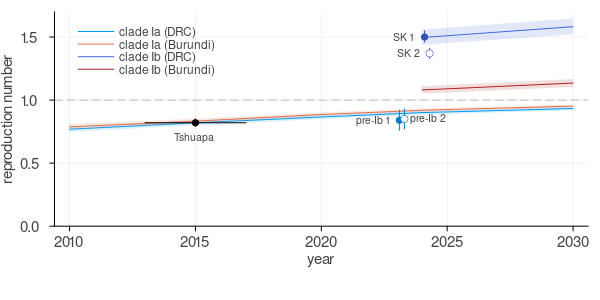

In [10]:
# plot
years_vec = [2010, 2015, 2020, 2024, 2030]

R0_drc = [quantile(scaled_nonsex_kivu[y], 0.5)   for y in years_vec]
R0_drc_low = [quantile(scaled_nonsex_kivu[y], 0.025) for y in years_vec]
R0_drc_up = [quantile(scaled_nonsex_kivu[y], 0.975) for y in years_vec]

R0_bdi = [quantile(scaled_nonsex_buri[y], 0.5)   for y in years_vec]
R0_bdi_low = [quantile(scaled_nonsex_buri[y], 0.025) for y in years_vec]
R0_bdi_up = [quantile(scaled_nonsex_buri[y], 0.975) for y in years_vec]

R0_drc_Ib = [quantile(scaled_total_kivu[y], 0.5)    for y in years_vec]
R0_drc_Ib_low = [quantile(scaled_total_kivu[y], 0.025)  for y in years_vec]
R0_drc_Ib_up = [quantile(scaled_total_kivu[y], 0.975)  for y in years_vec]

R0_bdi_Ib = [quantile(scaled_total_buri[y], 0.5)    for y in years_vec]
R0_bdi_Ib_low = [quantile(scaled_total_buri[y], 0.025)  for y in years_vec]
R0_bdi_Ib_up = [quantile(scaled_total_buri[y], 0.975)  for y in years_vec]

drc_halfwidth = (R0_drc .- R0_drc_low, R0_drc_up .- R0_drc)
bdi_halfwidth = (R0_bdi .- R0_bdi_low, R0_bdi_up .- R0_bdi)
drc_Ib_halfwidth = (R0_drc_Ib .- R0_drc_Ib_low, R0_drc_Ib_up .- R0_drc_Ib)
bdi_Ib_halfwidth = (R0_bdi_Ib .- R0_bdi_Ib_low, R0_bdi_Ib_up .- R0_bdi_Ib)

default_color = palette(:auto)[1]
colours = [:royalblue, 1, 2, :firebrick,
           RGBA(default_color*0.8,1.0),
           RGBA(65/255*0.8,105/255*0.8,225/255*0.8,1.0)]
bottom_margin = 10Plots.PlotMeasures.mm

sel = findall(x->x in (2024,2030), years_vec)

plt = plot([2015,2015], [0.79,0.85],
           color=:black, xlabel="year", ylabel="reproduction number",
           label="", ylim=(0,1.7), size=(600,300),
           bottom_margin=bottom_margin)

# clade Ia (DRC)
plot!(plt, years_vec, R0_drc,
      ribbon=drc_halfwidth, fillalpha=0.15,
      color=colours[2], label="clade Ia (DRC)")

# clade Ia (Burundi)
plot!(plt, years_vec, R0_bdi,
      ribbon=bdi_halfwidth, fillalpha=0.15,
      color=colours[3], label="clade Ia (Burundi)")

# clade Ib (DRC)
plot!(plt, years_vec[sel], R0_drc_Ib[sel],
      ribbon=(drc_Ib_halfwidth[1][sel], drc_Ib_halfwidth[2][sel]),
      fillalpha=0.15, color=colours[1], label="clade Ib (DRC)")

# clade Ib (Burundi)
plot!(plt, years_vec[sel], R0_bdi_Ib[sel],
      ribbon=(bdi_Ib_halfwidth[1][sel], bdi_Ib_halfwidth[2][sel]),
      fillalpha=0.15, color=colours[4], label="clade Ib (Burundi)")

hline!(plt, [1], color=RGBA(0.5,0.5,0.5,0.5),
       linestyle=:dash, label="")

scatter!(plt, [2015],[0.82], color=:black,
         marker=:circle, markersize=4, markerstrokewidth=0,
         label=nothing)
plot!(plt, [2013,2017],[0.82,0.82], color=:black, label=nothing)
annotate!(plt, 2015,0.7, text("Tshuapa","Helvetica",:black,7))

plot!(plt, [2023.1,2023.1], [0.76,0.92], color=colours[5], label=nothing)
scatter!(plt, [2023.1],[0.84], marker=:circle, color=colours[5],
         markersize=4, markerstrokewidth=0, label=nothing)
plot!(plt, [2023.3,2023.3], [0.77,0.93], color=colours[5], label=nothing)
scatter!(plt, [2023.3],[0.85],
         marker=:circle, markercolor=:white,
         markerstrokecolor=colours[5],
         markersize=4, markerstrokewidth=1, label=nothing)
annotate!(2022.1, 0.84, text("pre-Ib 1", "Helvetica", :black, 7), fontfamily="Helvetica")
annotate!(2024.3, 0.85, text("pre-Ib 2", "Helvetica", :black, 7), fontfamily="Helvetica")

plot!(plt, [2024.1,2024.1], [1.46,1.55], color=colours[6], label=nothing)
scatter!(plt, [2024.1],[1.50], marker=:circle, color=colours[6],
         markersize=4, markerstrokewidth=0, label=nothing)
plot!(plt, [2024.3,2024.3], [1.33,1.41], color=colours[6], label=nothing)
scatter!(plt, [2024.3],[1.37],
         marker=:circle, markercolor=:white,
         markerstrokecolor=colours[6],
         markersize=4, markerstrokewidth=1, label=nothing)
annotate!(plt, 2023.3,1.50, text("SK 1","Helvetica",:black,7))
annotate!(plt, 2023.5,1.37, text("SK 2","Helvetica",:black,7))

#savefig(plt, "fig_2b.svg")
display(plt)